# Real estate
Clean and generate queries

In [1]:
# imports and method definition cell
import pandas as pd
import numpy as np
import os
from relationalquerygeneration import *
import pyarrow.parquet as pq
import pyarrow as pa
import chardet


def cleanup(out):
    for file in os.listdir(out):
        if file.endswith(".pkl"):
            path_to_file = os.path.join(out, file)
            os.remove(path_to_file)
    # make sure directory is empty
    assert len(os.listdir(out)) <= 1, "Directory not empty"

# controls k 
ALPHA = 10

In [2]:
df = pd.read_csv('data/skipping_data_raw/Real_Estate_Sales_2001-2020_GL.csv')

# drop all columns besides List Year, Town
# df = df[['List Year', 'Town', 'Address', 'Assessed Value', 'Sale Amount']]
df = df[['List Year', 'Town', 'Address']]


# drop all rows with missing values
df = df.dropna()

# remove non alphabetic characters except spaces
df['Address'] = df['Address'].str.replace('[^a-zA-Z\s]', '')

# remove leading and trailing spaces
df['Address'] = df['Address'].str.strip()

print("Number of rows remaining: " + str(len(df.index)))
print("Number of unique streets: " + str(len(df['Address'].unique())))
print("Number of unique towns: " + str(len(df['Town'].unique())))

# sort by year
df = df.sort_values(by=['List Year'], ascending=False)

base = 1.25

df['utility'] = base**(df['List Year'] - df['List Year'].min()+1.0) + np.random.uniform(0, 10, len(df.index))   

# sort df by utility
df = df.sort_values(by=['utility'], ascending=False)
# reset index
df = df.reset_index(drop=True)

# remove spaces in column names
df.columns = df.columns.str.replace(' ', '')

df.head()

/var/folders/q7/3yvrc6352t1c2bwlqpsvkzy80000gn/T/ipykernel_89653/3337347582.py:1: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/skipping_data_raw/Real_Estate_Sales_2001-2020_GL.csv')
/var/folders/q7/3yvrc6352t1c2bwlqpsvkzy80000gn/T/ipykernel_89653/3337347582.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Address'] = df['Address'].str.replace('[^a-zA-Z\s]', '')


Number of rows remaining: 997162
Number of unique streets: 99752
Number of unique towns: 170


,ListYear,Town,Address,utility
0,2020,Manchester,CASTLE HILL,96.736141
1,2020,Glastonbury,OXBOW DR B,96.735948
2,2020,Cornwall,KENT RD,96.735718
3,2020,Greenwich,NORTHWAY,96.735601
4,2020,Granby,FERN HOLLOW DR,96.735535


In [3]:
start=10
k = int(((370+135)/2)//ALPHA)
print('k:', k)
df.groupby(['Town',	'Address']).size().sort_values(ascending=False).iloc[start:start+251]

k: 25


Town         Address            
New Haven    QUINNIPIAC AVE         370
Glastonbury  MAIN ST                355
Stamford     STRAWBERRY HILL AVE    346
Danbury      SOUTH ST               344
Vernon       TALCOTTVILLE RD        342
                                   ... 
Hartford     HILLSIDE AVE           136
New Haven    WOODWARD AVE           135
Suffield     MOUNTAIN RD            135
Darien       WEST AVE               135
Bridgeport   WILLIAM ST             135
Length: 251, dtype: int64

Generated 250 queries
Average position: 0.167585174725872
Max position: 0.6643203411281217


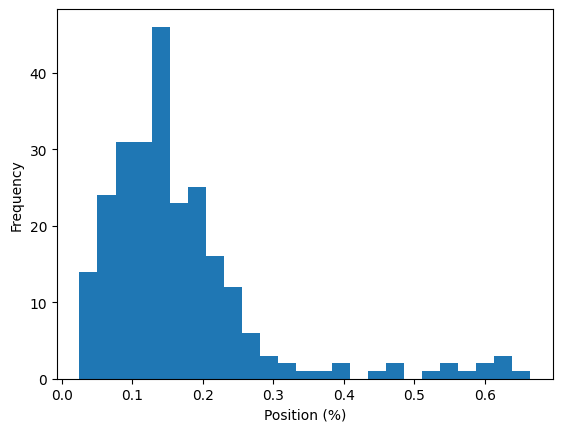

In [4]:
# k=10
n_queries = 250

df_no_listyr  = df.drop(columns=['ListYear'])

rg = RelationalGenerator(df_no_listyr)

cat_columns = ['Town', 'Address']


out = "data/skipping_data_processed/Real_Estate/queries"

cleanup(out)

# rg.generate_queries(cat_columns, k, n_queries, out, 0.5, 0.4)
rg.generate_queries(cat_columns, k, n_queries, out, 0.6, 0.5, start = start)

Text(0, 0.5, 'Utility')

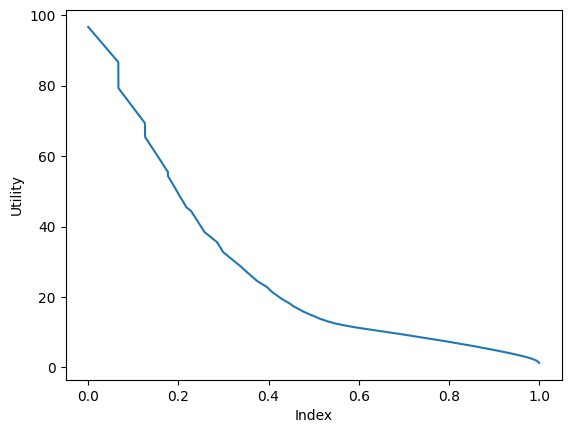

In [5]:
# load utilities 
utils = np.load("data/skipping_data_processed/Real_Estate/utilities.npy")
# plot utility vs index
plt.plot([i/len(utils) for i in list(range(0, len(utils)))], utils)
plt.xlabel("Index")
plt.ylabel("Utility")

In [6]:


# rg_size = 500
# rg_size = 2500
rg_size = 2000
# rg_size = 1000

# save utilities to numpy array
np.save('data/skipping_data_processed/Real_Estate/utilities/utilities.npy', df['utility'].to_numpy())

# remove utility and listyear columns
df = df.drop(columns=['utility', 'ListYear'])

# write to parquet with row group size rg_size
pq.write_table(pa.Table.from_pandas(df), 'data/skipping_data_processed/Real_Estate/parquet/Real_Estate_Sales_2001-2020.parquet', row_group_size=rg_size)

# Electric vehicles
Clean and generate queries


In [7]:
df = pd.read_csv('data/skipping_data_raw/Electric_Vehicle_Population_Data.csv')

df = df[['County', 'City', 'Postal Code', 'Model Year' ,'Make','Model', 'Legislative District']]

df = df.dropna()

# sort by model year
df = df.sort_values(by=['Model Year'], ascending=False)

base = 1.18

df['utility'] = base**(df['Model Year'] - df['Model Year'].min()+1.0) + np.random.uniform(0, 10, len(df.index))

# sort df by utility
df = df.sort_values(by=['utility'], ascending=False)

# reset index
df = df.reset_index(drop=True)

df['Legislative District'] = df['Legislative District'].astype(int).astype(str)
df['Postal Code'] = df['Postal Code'].astype(int).astype(str)

df.head()

,County,City,Postal Code,Model Year,Make,Model,Legislative District,utility
0,Pierce,Graham,98338,2024,JEEP,WRANGLER,2,112.959684
1,Lewis,Centralia,98531,2024,JEEP,WRANGLER,20,112.951644
2,Snohomish,Lynnwood,98036,2024,BMW,I7,32,112.943459
3,King,Sammamish,98075,2024,MAZDA,CX-90,41,112.939003
4,King,Bellevue,98004,2024,BMW,X5,48,112.935277


In [8]:
start = 5
k = int(((341+48)/2)//ALPHA)
print('k:', k)
df.groupby(['County', 'City', 'Postal Code', 'Model Year' ,'Make','Model', 'Legislative District']).size().sort_values(ascending=False).iloc[start:start+251]


k: 19


County     City          Postal Code  Model Year  Make       Model    Legislative District
Snohomish  Bothell       98012        2023        TESLA      MODEL Y  1                       341
                         98021        2023        TESLA      MODEL Y  1                       315
King       Sammamish     98074        2023        TESLA      MODEL Y  45                      315
                         98075        2023        TESLA      MODEL Y  41                      293
           Tukwila       98188        2023        CHEVROLET  BOLT EV  11                      201
                                                                                             ... 
Snohomish  Lake Stevens  98258        2021        TESLA      MODEL Y  44                       48
           Everett       98208        2023        TESLA      MODEL 3  44                       48
King       Seattle       98125        2021        TESLA      MODEL Y  46                       48
           Woodinville   98

In [9]:
# remove whitespaces frmo column names
df.columns = df.columns.str.replace(' ', '')

# k = 10
n_queries = 250

df_no_modelyr  = df.drop(columns=['ModelYear'])



Generated 250 queries
Average position: 0.18265582862448276
Max position: 0.7169094363521216


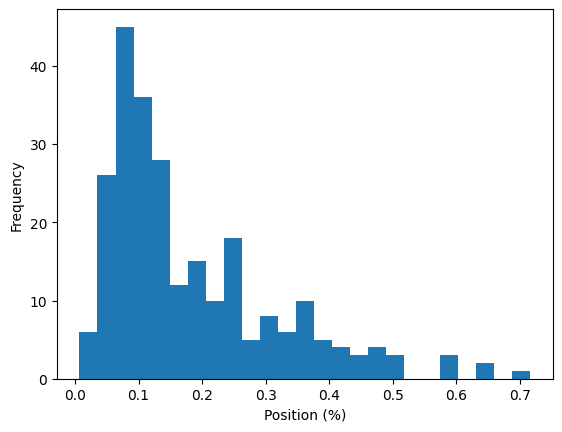

In [10]:
cat_columns = ['County', 'City', 'PostalCode', 'Make', 'Model', 'LegislativeDistrict']

out = "data/skipping_data_processed/Electric_Vehicles/queries"

cleanup(out)

rg = RelationalGenerator(df_no_modelyr)

# rg.generate_queries(cat_columns, k, n_queries, out, 0.5, 0.4)
rg.generate_queries(cat_columns, k, n_queries, out, 0.6, 0.5, start=start)

Text(0, 0.5, 'Utility')

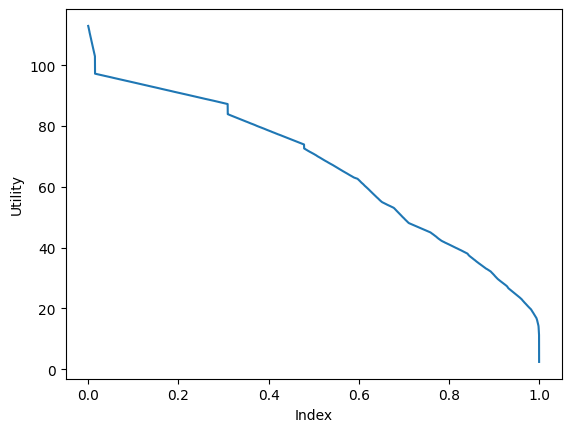

In [11]:
utils = np.load("data/skipping_data_processed/Electric_Vehicles/utilities/utilities.npy")
# plot utility vs index
plt.plot([i/len(utils) for i in list(range(0, len(utils)))], utils)
plt.xlabel("Index")
plt.ylabel("Utility")


In [12]:
rg_size = 350

# save utilities to numpy array
np.save('data/skipping_data_processed/Electric_Vehicles/utilities/utilities.npy', df['utility'].to_numpy())

# remove utility and modelyear columns
df = df.drop(columns=['utility', 'ModelYear'])

# write to parquet with row group size rg_size
pq.write_table(pa.Table.from_pandas(df), 'data/skipping_data_processed/Electric_Vehicles/parquet/Electric_Vehicle_Population_Data.parquet', row_group_size=rg_size)


# NASA HTTP logs
Cleaning and query generation

In [13]:
raw_nasa_files = ['data/skipping_data_raw/NASA_access_log_Aug95', 'data/skipping_data_raw/NASA_access_log_Jul95']

# detect encoding of files on first 1000 lines
encoding_types = []
for file in raw_nasa_files:
    with open(file, 'rb') as f:
        result = chardet.detect(f.read(10000))
        encoding_types.append(result['encoding'])
    
assert encoding_types[0] == encoding_types[1], "Files have different encodings"

# read in files with detected encoding
lines = []
for file in raw_nasa_files:
    i = 0
    with open(file, encoding=encoding_types[0]) as f:
        while True:
            try:
                line = f.readline()
                if not line:
                    break
                lines.append(line)
            except:
                print("Line {} not added in file {}".format(i, file))
            i += 1

Line 613123 not added in file data/skipping_data_raw/NASA_access_log_Aug95
Line 613508 not added in file data/skipping_data_raw/NASA_access_log_Aug95
Line 829742 not added in file data/skipping_data_raw/NASA_access_log_Aug95
Line 1437373 not added in file data/skipping_data_raw/NASA_access_log_Aug95
Line 1516936 not added in file data/skipping_data_raw/NASA_access_log_Aug95
Line 1530211 not added in file data/skipping_data_raw/NASA_access_log_Aug95
Line 1538760 not added in file data/skipping_data_raw/NASA_access_log_Aug95
Line 118894 not added in file data/skipping_data_raw/NASA_access_log_Jul95
Line 118895 not added in file data/skipping_data_raw/NASA_access_log_Jul95
Line 550847 not added in file data/skipping_data_raw/NASA_access_log_Jul95
Line 1031344 not added in file data/skipping_data_raw/NASA_access_log_Jul95
Line 1352887 not added in file data/skipping_data_raw/NASA_access_log_Jul95
Line 1453988 not added in file data/skipping_data_raw/NASA_access_log_Jul95
Line 1498504 not a

In [14]:
# split lines into columns
lines = [line.split(' ') for line in lines]
# create pandas dataframe from lines
print("Number of rows original: " + str(len(lines)))
lines = [line for line in lines if len(line) == 10]
print("Number of rows remaining: " + str(len(lines)))
df = pd.DataFrame(lines, columns=['Host', 'Junk1', 'Junk2', 'Timestamp', 'Junk3', 'RequestType', 'Asset', 'Junk4', 'Junk5', 'Junk6'])

Number of rows original: 3460463
Number of rows remaining: 3452337


In [15]:
# drop rows with missing values
df = df.dropna()

# remove brackets from timestamp and convert to datetime
df['Timestamp'] = df['Timestamp'].str.replace('[', '')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%b/%Y:%H:%M:%S')

# remove quote from request type
df['RequestType'] = df['RequestType'].str.replace('"', '')

# remove all columns with name starting with Junk
df = df[df.columns.drop(list(df.filter(regex='Junk')))]
# drop request type column
df = df.drop(columns=['RequestType'])

df.head()

/var/folders/q7/3yvrc6352t1c2bwlqpsvkzy80000gn/T/ipykernel_89653/554104093.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Timestamp'] = df['Timestamp'].str.replace('[', '')


,Host,Timestamp,Asset
0,in24.inetnebr.com,1995-08-01 00:00:01,/shuttle/missions/sts-68/news/sts-68-mcc-05.txt
1,uplherc.upl.com,1995-08-01 00:00:07,/
2,uplherc.upl.com,1995-08-01 00:00:08,/images/ksclogo-medium.gif
3,uplherc.upl.com,1995-08-01 00:00:08,/images/MOSAIC-logosmall.gif
4,uplherc.upl.com,1995-08-01 00:00:08,/images/USA-logosmall.gif


In [16]:
# check grouoby of host and asset
start = 100
k = int(((4110+1042)/2)//ALPHA)
print('k:', k)
df.groupby(['Asset']).size().sort_values(ascending=False).iloc[start:start+251]

k: 257


Asset
/shuttle/missions/sts-70/movies/woodpecker.mpg          4110
/shuttle/resources/orbiters/discovery-logo.gif          4086
/whats-new.html                                         4035
/history/apollo/apollo-13/images/                       4019
/icons/movie.xbm                                        4006
                                                        ... 
/facilities/crawler.html                                1055
/shuttle/missions/sts-70/images/KSC-95EC-0768.jpg       1054
/software/winvn/userguide/winvnsm.gif                   1049
/shuttle/missions/sts-70/images/woodpecker-on-et.gif    1044
/shuttle/missions/sts-71/images/KSC-95EC-0916.gif       1042
Length: 251, dtype: int64

In [17]:
# generate utilities
base = 1.075
df['utility'] = base**((df['Timestamp'] - df['Timestamp'].min()).dt.days+1.0) + np.random.uniform(0, 10, len(df.index))


# sort df by utility
df = df.sort_values(by=['utility'], ascending=False)

# reset index
df = df.reset_index(drop=True)

df_no_timestamp  = df.drop(columns=['Timestamp', 'Host'])

In [18]:
# k = 100
n_queries = 250

cat_columns = ['Asset']

out = "data/skipping_data_processed/Nasa/queries"



Generated 250 queries
Average position: 0.19229225767936328
Max position: 0.5764660286640615


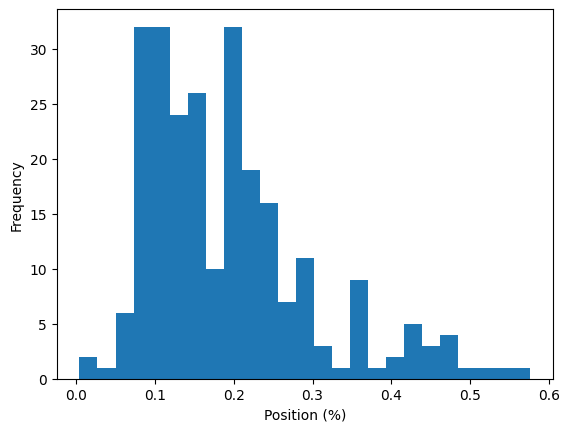

In [19]:
cleanup(out)
rg = RelationalGenerator(df_no_timestamp)

# rg.generate_queries(cat_columns, k, n_queries, out, 0.5, 0.4, start = 100)
rg.generate_queries(cat_columns, k, n_queries, out, 0.6, 0.5, start = start)

Text(0, 0.5, 'Utility')

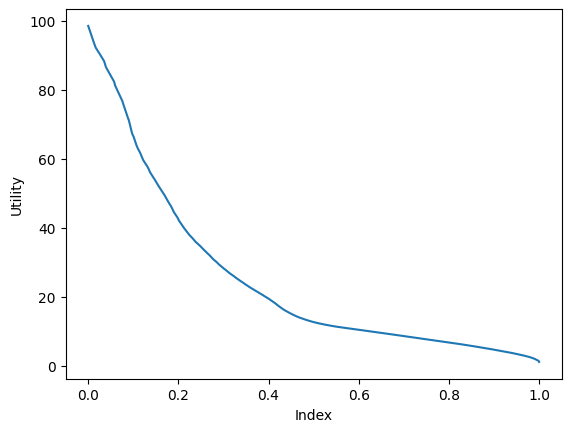

In [20]:
# load utilities
utils = np.load("data/skipping_data_processed/Nasa/utilities/utilities.npy")
# plot utility vs index
plt.plot([i/len(utils) for i in list(range(0, len(utils)))], utils)
plt.xlabel("Index")
plt.ylabel("Utility")

In [21]:
rg_size = 2500

# save utilities to numpy array
np.save('data/skipping_data_processed/Nasa/utilities/utilities.npy', df['utility'].to_numpy())

# remove utility and timestamp columns
df = df.drop(columns=['utility', 'Timestamp', 'Host'])

# write to parquet with row group size rg_size
pq.write_table(pa.Table.from_pandas(df), 'data/skipping_data_processed/Nasa/parquet/Nasa.parquet', row_group_size=rg_size)

In [22]:
# load in the parquet file for each dataset and check the number of columns and row groups
# for each dataset
for path in ['data/skipping_data_processed/Real_Estate/parquet/Real_Estate_Sales_2001-2020.parquet', 'data/skipping_data_processed/Electric_Vehicles/parquet/Electric_Vehicle_Population_Data.parquet', 'data/skipping_data_processed/Nasa/parquet/Nasa.parquet']:
    # read in parquet file
    table = pq.read_table(path)
    # get number of columns
    print("Number of columns in {}: {}".format(path.split('/')[-1], table.num_columns))
    print("Number of rows in {}: {}".format(path.split('/')[-1], table.num_rows))

Number of columns in Real_Estate_Sales_2001-2020.parquet: 2
Number of rows in Real_Estate_Sales_2001-2020.parquet: 997162
Number of columns in Electric_Vehicle_Population_Data.parquet: 6
Number of rows in Electric_Vehicle_Population_Data.parquet: 162637
Number of columns in Nasa.parquet: 1
Number of rows in Nasa.parquet: 3452337
